# CV  Simulations: Replicating Varoquaux#
    - Matt Robinson, matthew67robinson@gmail.com
    
Much of the code borrowed from https://github.com/GaelVaroquaux/cross_validation_failure

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats

In [2]:
"""
Simple simulation code to reproduce figures on high variance of
small-sample cross-validation.
"""
from scipy import ndimage

from joblib import Parallel, delayed, Memory
from sklearn.model_selection import (GroupShuffleSplit, LeaveOneOut,
        cross_val_score, KFold, StratifiedKFold)
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.svm import LinearSVC

In [3]:
def mk_data(n_samples=200, random_state=0, separability=1,
            noise_corr=2, dim=100):
    rng = np.random.RandomState(random_state)
    y = rng.randint(0, 1 + 1, size=n_samples)
    noise = rng.normal(size=(n_samples, dim))
    if not noise_corr is None and noise_corr > 0:
        noise = ndimage.gaussian_filter1d(noise, noise_corr, axis=0)
    noise = noise / noise.std(axis=0)
    # We need to decrease univariate separability as dimension increases
    centers = 4. / dim * np.ones((2, dim))
    centers[0] *= -1
    X = separability * centers[y] + noise
    return X, y

In [4]:
def sample_and_cross_val_clf(train_size=200, noise_corr=2, dim=3, sep=.5,
                             random_state=0, n_folds_list=[3]):
    """ Runs an experiment and returns the corresponding lines in
        the results dataframe.
    """
    clf = LinearSVC(penalty='l2', fit_intercept=True)

    n_samples = train_size + 10000
    y_test = np.array([0,1]) #placeholder
    while ((sum(y_test[y_test==1]) < 3) and (sum(y_test[y_test==0]) < 3)):
        X, y = mk_data(n_samples=n_samples,
                       separability=sep, random_state=random_state,
                       noise_corr=noise_corr, dim=dim)
        X_train = X[:train_size]
        y_train = y[:train_size]
        X_test = X[train_size:]
        y_test = y[train_size:]

    validation_score = roc_auc_score(
                            y_test,
                            clf.fit(X_train, y_train).decision_function(X_test))

    scores = list()
    for n_folds in n_folds_list:
        name = f'{n_folds}-fold'
        this_scores = cross_val_score(clf, X_train, y_train,
                                      cv=StratifiedKFold(n_splits=n_folds, random_state=0),
                                      scoring='roc_auc')
        scores.append(dict(
            cv_name=name,
            validation_score=validation_score,
            train_size=train_size,
            dim=dim,
            noise_corr=noise_corr,
            sep=sep,
            score_error=(np.mean(this_scores) - validation_score),
            score_sem=(np.std(this_scores) / np.sqrt(len(this_scores))),
            ))

    return scores

We tune the classifier to achieve approximate generalization performance of AUC-ROC = 0.75 with 300 samples to train on

In [5]:
sample_and_cross_val_clf(train_size=300,
                         noise_corr=0,
                         dim=300,
                         sep=4.1745,
                         random_state=0)

[{'cv_name': '3-fold',
  'validation_score': 0.7523227500570058,
  'train_size': 300,
  'dim': 300,
  'noise_corr': 0,
  'sep': 4.1745,
  'score_error': -0.010991550910680492,
  'score_sem': 0.010876737792032807}]

In [ ]:
# Run the simulations

N_JOBS = -1
N_DRAWS = 1000
#mem = Memory(cachedir='cache')


results = pd.DataFrame(
    columns=['cv_name', 'validation_score', 'train_size', 'dim',
             'noise_corr', 'sep', 'score_error', 'score_sem'])


for sep in (4.1745, ): # gives real ROCAUC ~ 0.75 with train size 200
    for train_size in (30, 100, 300, 1000):
    #for train_size in [1000]:
        # Cap computing time
        n_draws = N_DRAWS if train_size < 500 else int(N_DRAWS / 10)
        scores = Parallel(n_jobs=N_JOBS, verbose=10)(
                    delayed(sample_and_cross_val_clf)(
                            train_size=train_size,
                            noise_corr=0, dim=300, sep=sep,
                            random_state=i)
                    for i in range(n_draws))
        for line in scores:
            results = results.append(line)

results.to_csv('cross_validation_results.csv')

# Load data

In [6]:
results = pd.read_csv('cross_validation_results.csv')
results.head()

,Unnamed: 0,cv_name,validation_score,train_size,dim,noise_corr,sep,score_error,score_sem
0,0,3-fold,0.649848,30,300,0,4.1745,0.008485,0.048273
1,0,3-fold,0.649974,30,300,0,4.1745,0.194470,0.065420
2,0,3-fold,0.658517,30,300,0,4.1745,-0.189072,0.088744
3,0,3-fold,0.643951,30,300,0,4.1745,0.200493,0.070856
4,0,3-fold,0.668221,30,300,0,4.1745,-0.273777,0.061027


In [27]:
def plot_scores(scores, original_score, confidence=0.95,
                title='', bins=None):
    sorted_scores = np.array(scores)
    sorted_scores.sort()
    
    # Computing the lower and upper bound of the 90% confidence interval
    # You can change the bounds percentiles to 0.025 and 0.975 to get
    # a 95% confidence interval instead.
    lower_pct = (1-(confidence))/2
    upper_pct = 1 - lower_pct
    confidence_lower = sorted_scores[int(lower_pct * len(sorted_scores))]
    confidence_upper = sorted_scores[int(upper_pct * len(sorted_scores))]
    
    
    # I think this is right, but check geq sign
    #print(f'ONE-SIDED P-VALUE: {np.mean(original_score <= sorted_scores)}')
    
    if bins:
        plt.hist(sorted_scores, alpha=0.3, density=True, bins=bins)
    else:
        plt.hist(sorted_scores, alpha=0.3, density=True)
    plt.tight_layout()
    plt.axvline(x=original_score,c='red',zorder=10,label='Mean estimation error')
    plt.axvline(x=confidence_lower,c='k',linestyle='dashed',zorder=10,
                label='95% CI limits')
    plt.axvline(x=confidence_upper,c='k',linestyle='dashed',zorder=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('CV Estimation Error of AUC-ROC', fontsize=14)
    plt.ylabel('density', fontsize=14)
    plt.title(title, fontsize=16)
    plt.axvline(x=original_score)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.93))

# Plot the error of CV procedure estimating the generalization performance #

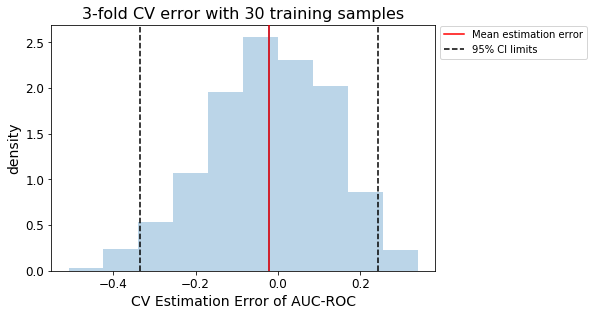

In [28]:
scores = results[results['train_size']==30]['score_error']
plot_scores(scores, np.mean(scores),title='3-fold CV error with 30 training samples')

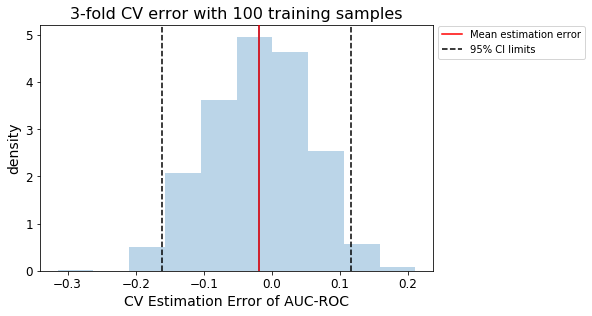

In [29]:
scores = results[results['train_size']==100]['score_error']
plot_scores(scores, np.mean(scores),title='3-fold CV error with 100 training samples')

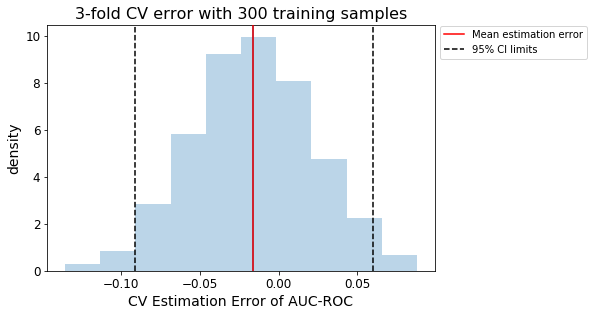

In [30]:
scores = results[results['train_size']==300]['score_error']
plot_scores(scores, np.mean(scores),title='3-fold CV error with 300 training samples')

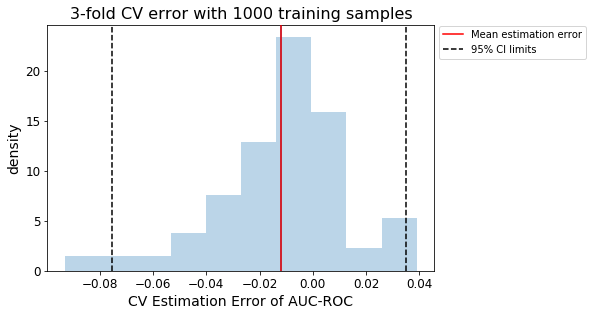

In [31]:
scores = results[results['train_size']==1000]['score_error']
plot_scores(scores, np.mean(scores),title='3-fold CV error with 1000 training samples')

# Determine how good the SEM is at estimating error: #

In [12]:
import scipy.stats
t_95 = scipy.stats.t.ppf(0.975, df=3-1)

results['conf_int_width'] = t_95*results['score_sem']
results['abs_error'] = np.abs(results['score_error'])
results['CI_covers'] = results['abs_error'] <= results['conf_int_width']

results.head()

,Unnamed: 0,cv_name,validation_score,train_size,dim,noise_corr,sep,score_error,score_sem,conf_int_width,abs_error,CI_covers
0,0,3-fold,0.649848,30,300,0,4.1745,0.008485,0.048273,0.207700,0.008485,True
1,0,3-fold,0.649974,30,300,0,4.1745,0.194470,0.065420,0.281481,0.194470,True
2,0,3-fold,0.658517,30,300,0,4.1745,-0.189072,0.088744,0.381835,0.189072,True
3,0,3-fold,0.643951,30,300,0,4.1745,0.200493,0.070856,0.304869,0.200493,True
4,0,3-fold,0.668221,30,300,0,4.1745,-0.273777,0.061027,0.262577,0.273777,False


In [15]:
print('Coverage proportion for train size of 30: ')
np.mean(results[results['train_size']==30]['CI_covers'])

Coverage proportion for train size of 30: 


0.796

Text(0.01,0.4,'CI covers')

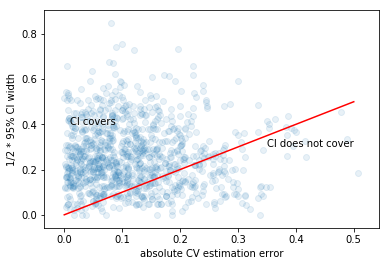

In [14]:
plt.scatter(np.abs(results[results['train_size']==30]['score_error']),
            results[results['train_size']==30]['score_sem']*t_95,
           alpha=0.1)

plt.xlabel('absolute CV estimation error')
plt.ylabel('1/2 * 95% CI width')

x = np.linspace(0,0.5,100)
plt.plot(x,x,'r')

plt.text(0.35,0.3,'CI does not cover')
plt.text(0.01,0.4,'CI covers')

# plt.xlim((-0.02,0.35))
# plt.ylim((-0.02,0.35))

Look how large some of those CIs are...

In [16]:
print('Coverage proportion for train size of 100: ')
np.mean(results[results['train_size']==100]['CI_covers'])

Coverage proportion for train size of 100: 


0.8

(-0.02, 0.35)

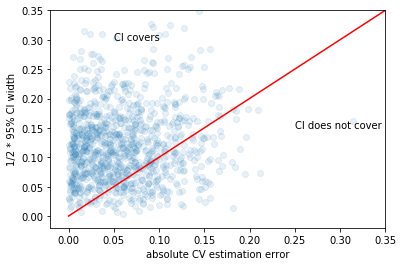

In [19]:
plt.scatter(np.abs(results[results['train_size']==100]['score_error']),
            results[results['train_size']==100]['score_sem']*t_95,
           alpha=0.1)

plt.xlabel('absolute CV estimation error')
plt.ylabel('1/2 * 95% CI width')

x = np.linspace(0,0.35,100)
plt.plot(x,x,'r')

plt.text(0.25,0.15,'CI does not cover')
plt.text(0.05,0.30,'CI covers')

plt.xlim((-0.02,0.35))
plt.ylim((-0.02,0.35))

In [17]:
print('Coverage proportion for train size of 300: ')
np.mean(results[results['train_size']==300]['CI_covers'])

Coverage proportion for train size of 300: 


0.797

Text(0,0.11,'CI covers')

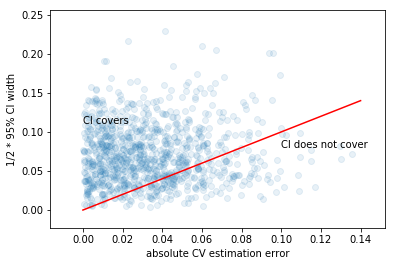

In [20]:
plt.scatter(np.abs(results[results['train_size']==300]['score_error']),
            results[results['train_size']==300]['score_sem']*t_95,
           alpha=0.1)

plt.xlabel('absolute CV estimation error')
plt.ylabel('1/2 * 95% CI width')

x = np.linspace(0,0.14,100)
plt.plot(x,x,'r')

plt.text(0.1,0.08,'CI does not cover')
plt.text(0.00,0.11,'CI covers')

In [18]:
print('Coverage proportion for train size of 1000: ')
np.mean(results[results['train_size']==1000]['CI_covers'])

Coverage proportion for train size of 1000: 


0.76

Text(0,0.11,'CI covers')

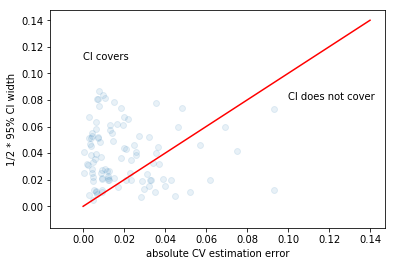

In [21]:
plt.scatter(np.abs(results[results['train_size']==1000]['score_error']),
            results[results['train_size']==1000]['score_sem']*t_95,
           alpha=0.1)

plt.xlabel('absolute CV estimation error')
plt.ylabel('1/2 * 95% CI width')

x = np.linspace(0,0.14,100)
plt.plot(x,x,'r')

plt.text(0.1,0.08,'CI does not cover')
plt.text(0.00,0.11,'CI covers')